In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy201_png_jpg.rf.1d483e3b4cc695fdc266f89358560004.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy274_png_jpg.rf.0686e0d71851d0b6c39672acf4daa70b.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy102_png_jpg.rf.067b82772a59a84a610dca8ca271823b.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy61_png_jpg.rf.029a24b5426baee2cee7ba360813f6cb.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy12_png_jpg.rf.0e45608c1e5a811769e9e40d8e8a492c.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy554_png_jpg.rf.b0bb671dd72e14033534d4c4725b3df5.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Guppy/Guppy31_png_jpg.rf.a590d539cc980ddec06432ef3555f260.jpg
/kaggle/input/dataset-fish-classification/dataset fish classification/Gu

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/kaggle/input/dataset-fish-classification/dataset fish classification'

# The paths for the training and validation directories
train_dir = '/kaggle/working/training'
val_dir = '/kaggle/working/validation'

# The categories of your gym equipment
categories = ['Fighting','Gold', 'Guppy', 'Koi']

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in categories:
    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    
    # Get the full path for the current category
    category_path = os.path.join(dataset_dir, category)
    
    # Check if the category path exists
    if not os.path.exists(category_path):
        print(f"Category path does not exist: {category_path}")
        continue
    
    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Split the files into training and validation sets
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio)
    
    # Copy the training files to the training directory
    for file_name in train_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(train_dir, category, file_name))
        
    # Copy the validation files to the validation directory
    for file_name in val_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(val_dir, category, file_name))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Define paths
base_dir = '/kaggle/working'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

In [5]:
# Define image dimensions
img_width, img_height = 150, 150
batch_size = 32

In [6]:
# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2613 images belonging to 4 classes.
Found 655 images belonging to 4 classes.


In [7]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


9406464/9406464 [==============================] - 0s 0us/step


In [8]:
# Define the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Final output layer with 4 classes
])

In [9]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [10]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
            print('\nReached 98% accuracy for both training and validation. Stopping training.')
            self.model.stop_training = True
            
callback = AccuracyThresholdCallback()

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback]
)


Epoch 1/1000
81/81 [==============================] - 24s 230ms/step - loss: 0.3302 - accuracy: 0.8931 - val_loss: 0.0777 - val_accuracy: 0.9750
Epoch 2/1000
81/81 [==============================] - 18s 220ms/step - loss: 0.1179 - accuracy: 0.9616 - val_loss: 0.0684 - val_accuracy: 0.9781
Epoch 3/1000
81/81 [==============================] - 18s 221ms/step - loss: 0.0900 - accuracy: 0.9729 - val_loss: 0.0501 - val_accuracy: 0.9812
Epoch 4/1000
81/81 [==============================] - 18s 221ms/step - loss: 0.0966 - accuracy: 0.9644 - val_loss: 0.0460 - val_accuracy: 0.9844
Epoch 5/1000
81/81 [==============================] - 18s 221ms/step - loss: 0.0706 - accuracy: 0.9779 - val_loss: 0.0492 - val_accuracy: 0.9859
Epoch 6/1000
81/81 [==============================] - 18s 221ms/step - loss: 0.0688 - accuracy: 0.9768 - val_loss: 0.0435 - val_accuracy: 0.9891
Epoch 7/1000
81/81 [==============================] - 18s 219ms/step - loss: 0.0552 - accuracy: 0.9795 - val_loss: 0.0390 - val_ac

In [12]:
# Save the model
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 3s 85ms/step


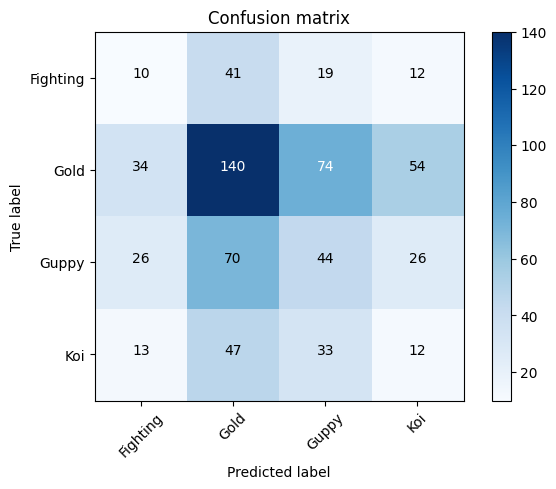

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(validation_generator, validation_generator.samples // batch_size+1)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Class names
class_names = ['Fighting','Gold', 'Guppy', 'Koi']

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix with class names
plot_confusion_matrix(confusion_mtx, classes=class_names)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484

In [15]:
class_indices = train_generator.class_indices
print(class_indices)  

{'Fighting': 0, 'Gold': 1, 'Guppy': 2, 'Koi': 3}


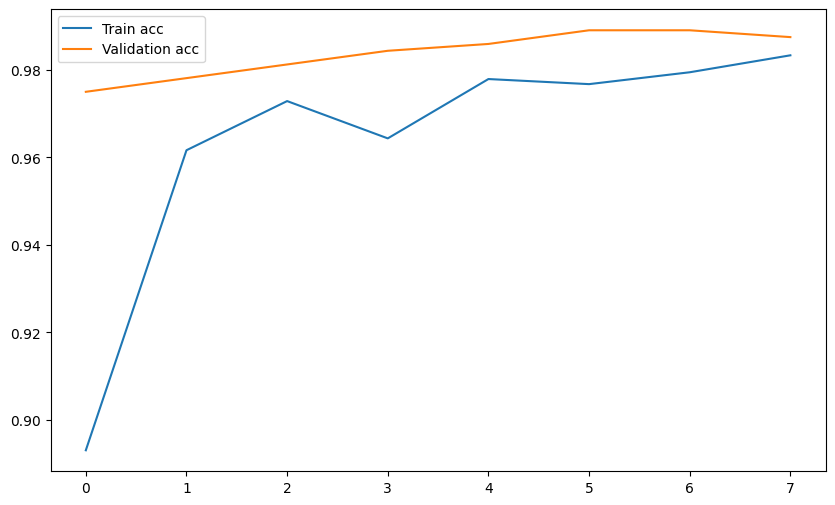

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

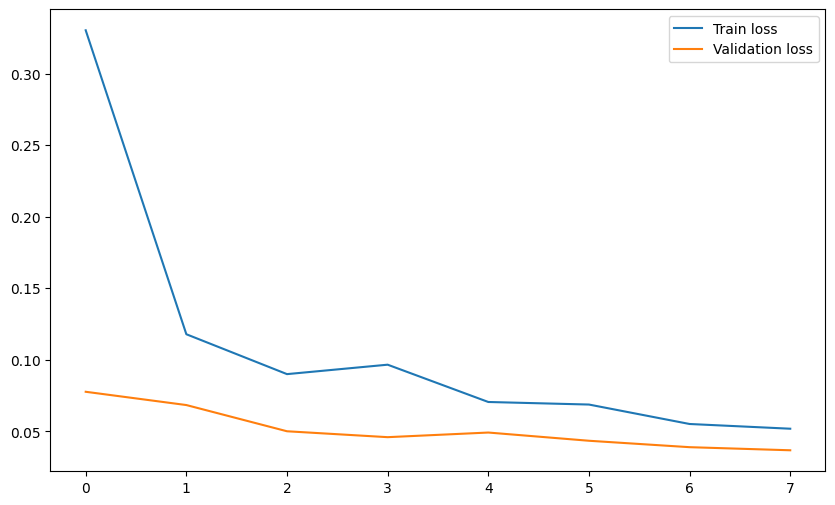

In [17]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 1s 782ms/step


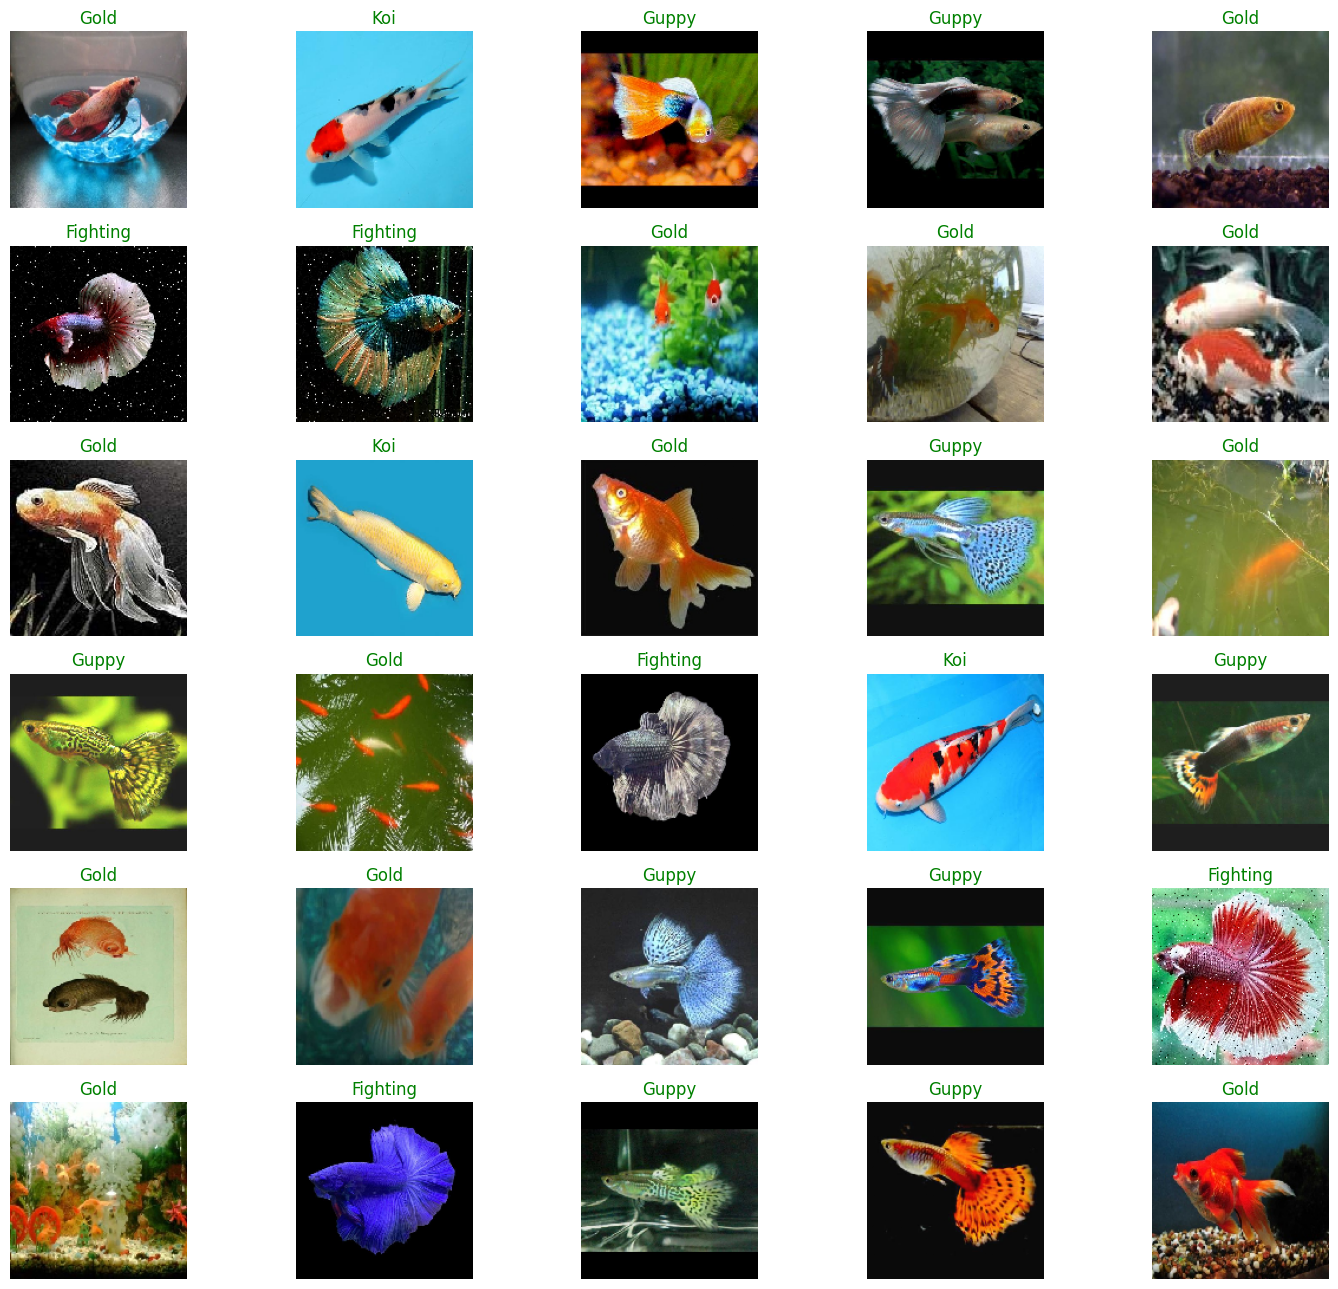

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/model.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Fighting': 0, 'Gold': 1, 'Guppy': 2, 'Koi': 3}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
